In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 0 Load Data

In [2]:
############################################################
# LOADING ADMISSIONS AND PATIENTS DF
############################################################
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2016_2018.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

In [3]:
# LOADING EOBS AND OXYGEN SATURATION BEFORE INTERPOLATION =============
data = pickle.load( open('DataFrame_pickles/df_eobs_oxygen_2016_2018_v2.pickle', 'rb'))
df_eobs_old = data[0]
df_oxyge    = data[1]
# LOADING EOBS AFTER INTERPOLATION ====================================
df_eobs_new = pickle.load( open('DataFrame_pickles/df_eobs_3d.pickle', 'rb'))
#df_eobs_new = pickle.load( open('DataFrame_pickles/df_eobs_3d_old.pickle', 'rb'))

# 1. Data Checks

### 1.1. Admissions

In [4]:
print('Admissions in admissions', len(df_admissions))
print('')

print('Admissions in Eobs_old', len(df_eobs_old['admission_id'].unique()))
print('Admissions in Eobs_new', len(df_eobs_new['admission_id'].unique()))

Admissions in admissions 23040

Admissions in Eobs_old 18537
Admissions in Eobs_new 13950


### 1.2 null values

In [5]:
df = pd.concat([df_eobs_old.isna().sum(), df_eobs_new.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df)
display(df_eobs_old.describe())

,nulls,type
admission_id,0.000,object
patient_id,0.000,NaN
timestamp,0.000,object
time_since_prev_obs_in_mins,0.000,object
rr,0.000,object
ews,0.000,object
heart_rate,8269.000,object
temperature\r,11692.000,object
timestamp_code,0.000,object
sbp,12093.000,object


,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,1137181.000,1137181.000,1137181.000,1137181.000,1128912.000,1125489.000,1137181.000,1125088.000,1125088.000
mean,50067041.037,49895159.897,18.856,2.194,85.020,36.852,17476.329,123.894,69.858
std,28603955.656,28801552.645,3.135,2.281,16.704,0.600,252.879,21.587,13.336
min,16944.000,12844.000,5.000,0.000,20.000,30.000,16807.034,60.000,40.000
25%,25321229.000,25684242.000,17.000,0.000,73.000,36.500,17253.454,109.000,61.000
50%,49846380.000,49621993.000,18.000,2.000,85.000,36.800,17498.554,121.000,69.000
75%,75029576.000,74761709.000,20.000,3.000,94.000,37.200,17681.768,137.000,78.000
max,99994971.000,99995681.000,40.000,21.000,160.000,42.000,18065.359,200.000,120.000


In [6]:
df = pd.concat([df_eobs_new.isna().sum(), df_eobs_new.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df)

df_eobs_new = df_eobs_new.astype({'rr':'float', 'ews':'float', 'heart_rate':'float', 'temperature\r':'float', 'sbp':'float', 'dbp':'float'})
display(df_eobs_new.describe())

,nulls,type
admission_id,0,object
timestamp,0,object
time_since_prev_obs_in_mins,0,object
rr,0,object
ews,0,object
heart_rate,0,object
temperature\r,0,object
timestamp_code,0,object
sbp,0,object
dbp,0,object


,rr,ews,heart_rate,temperature\r,sbp,dbp,Oxygen_Saturation,Assisted_O2
count,4017600.000,4017600.000,4017600.000,4017600.000,4017600.000,4017600.000,4017600.000,4017600.000
mean,18.718,1.899,83.927,36.907,126.728,70.660,95.794,0.987
std,2.514,1.927,15.015,0.564,19.966,12.235,2.535,0.112
min,5.000,0.000,20.000,30.000,60.000,40.000,60.000,0.000
25%,17.588,0.000,73.600,36.524,113.000,62.400,95.105,1.000
50%,18.000,2.000,83.444,36.827,124.429,69.938,96.000,1.000
75%,19.684,3.000,91.987,37.202,138.900,78.000,97.143,1.000
max,40.000,20.000,160.000,41.900,200.000,120.000,100.000,1.000


In [7]:
df_eobs_new.dtypes

admission_id                    object
timestamp                       object
time_since_prev_obs_in_mins     object
rr                             float64
ews                            float64
heart_rate                     float64
temperature\r                  float64
timestamp_code                  object
sbp                            float64
dbp                            float64
Oxygen_Saturation              float64
Assisted_O2                    float64
dtype: object

In [8]:
df_eobs_new

,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
0,92464775,2018-03-11 12:15:00,15,23.000,11.000,97.000,37.000,17601.513,83.000,40.000,98.000,1.000
1,92464775,2018-03-11 12:30:00,15,20.000,8.000,77.000,36.700,17601.524,75.000,57.000,96.000,1.000
2,92464775,2018-03-11 12:45:00,15,20.000,7.000,76.000,36.733,17601.532,77.000,61.667,95.667,1.000
3,92464775,2018-03-11 13:00:00,15,20.000,7.000,75.000,36.767,17601.540,79.000,66.333,95.333,1.000
4,92464775,2018-03-11 13:15:00,15,20.000,6.000,74.000,36.800,17601.549,81.000,71.000,95.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
283,35965296,2017-10-09 12:45:00,15,16.667,2.000,101.667,36.800,17448.530,107.667,77.333,98.000,1.000
284,35965296,2017-10-09 13:00:00,15,16.556,2.000,101.389,36.800,17448.540,108.056,77.444,97.833,1.000
285,35965296,2017-10-09 13:15:00,15,16.444,2.000,101.111,36.800,17448.550,108.444,77.556,97.667,1.000
286,35965296,2017-10-09 13:30:00,15,16.333,2.000,100.833,36.800,17448.560,108.833,77.667,97.500,1.000


In [9]:
df_admissions.columns

Index(['admission_id', 'episode_diagnoses', 'patient_id', 'age_at_admission\r',
       'admission_date_time', 'admission_date_code_time',
       'discharge_date_time', 'discharge_date_code_time', 'lengthofstay',
       'isPneumonia', 'mortal_admin', 'icu_count\r', 'Comorbidity_score'],
      dtype='object')

In [10]:
admins = df_eobs_new['admission_id'].unique().tolist()
adm = admins[0]

df_eobs_new.groupby(by=['admission_id']).count()

,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
admission_id,,,,,,,,,,,
16944,288,288,288,288,288,288,288,288,288,288,288
19658,288,288,288,288,288,288,288,288,288,288,288
32954,288,288,288,288,288,288,288,288,288,288,288
44400,288,288,288,288,288,288,288,288,288,288,288
49339,288,288,288,288,288,288,288,288,288,288,288
...,...,...,...,...,...,...,...,...,...,...,...
99983506,288,288,288,288,288,288,288,288,288,288,288
99990637,288,288,288,288,288,288,288,288,288,288,288
99991363,288,288,288,288,288,288,288,288,288,288,288


In [11]:
df_eobs_new[df_eobs_new['admission_id'] == 16944]

,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
0,16944,2018-12-12 07:15:00,15,30.000,8.000,95.000,35.800,17877.303,129.000,71.000,88.000,1.000
1,16944,2018-12-12 07:30:00,15,24.000,6.000,83.000,36.900,17877.310,109.000,72.000,94.000,1.000
2,16944,2018-12-12 07:45:00,15,22.000,4.000,80.000,36.900,17877.333,120.000,71.000,96.000,1.000
3,16944,2018-12-12 08:00:00,15,22.000,4.000,79.500,36.900,17877.344,119.333,69.667,96.333,1.000
4,16944,2018-12-12 08:15:00,15,22.000,4.000,79.000,36.900,17877.351,118.667,68.333,96.667,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
283,16944,2018-12-15 06:00:00,15,18.951,2.000,84.244,36.700,17880.253,116.244,91.317,96.098,1.000
284,16944,2018-12-15 06:15:00,15,18.976,2.000,84.122,36.700,17880.263,116.122,91.659,96.049,1.000
285,16944,2018-12-15 06:30:00,15,19.000,2.000,84.000,36.700,17880.274,116.000,92.000,96.000,1.000
286,16944,2018-12-15 06:45:00,15,19.000,2.000,84.579,36.700,17880.284,115.737,90.947,96.000,1.000


In [12]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

In [13]:
dict_labels = {'rr':'Respiratory rate','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation'}

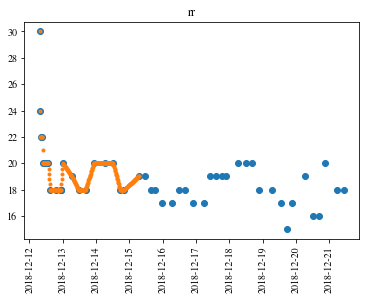

In [14]:

adm_no = 16944
field = 'rr'
adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
adm_old = df_eobs_old[df_eobs_old['admission_id'] == adm_no]

plt.plot(adm_old['timestamp'],adm_old[field], 'o')
plt.plot(adm_new['timestamp'],adm_new[field], '.')
plt.title(field)
plt.xticks(rotation = 90)
plt.show()

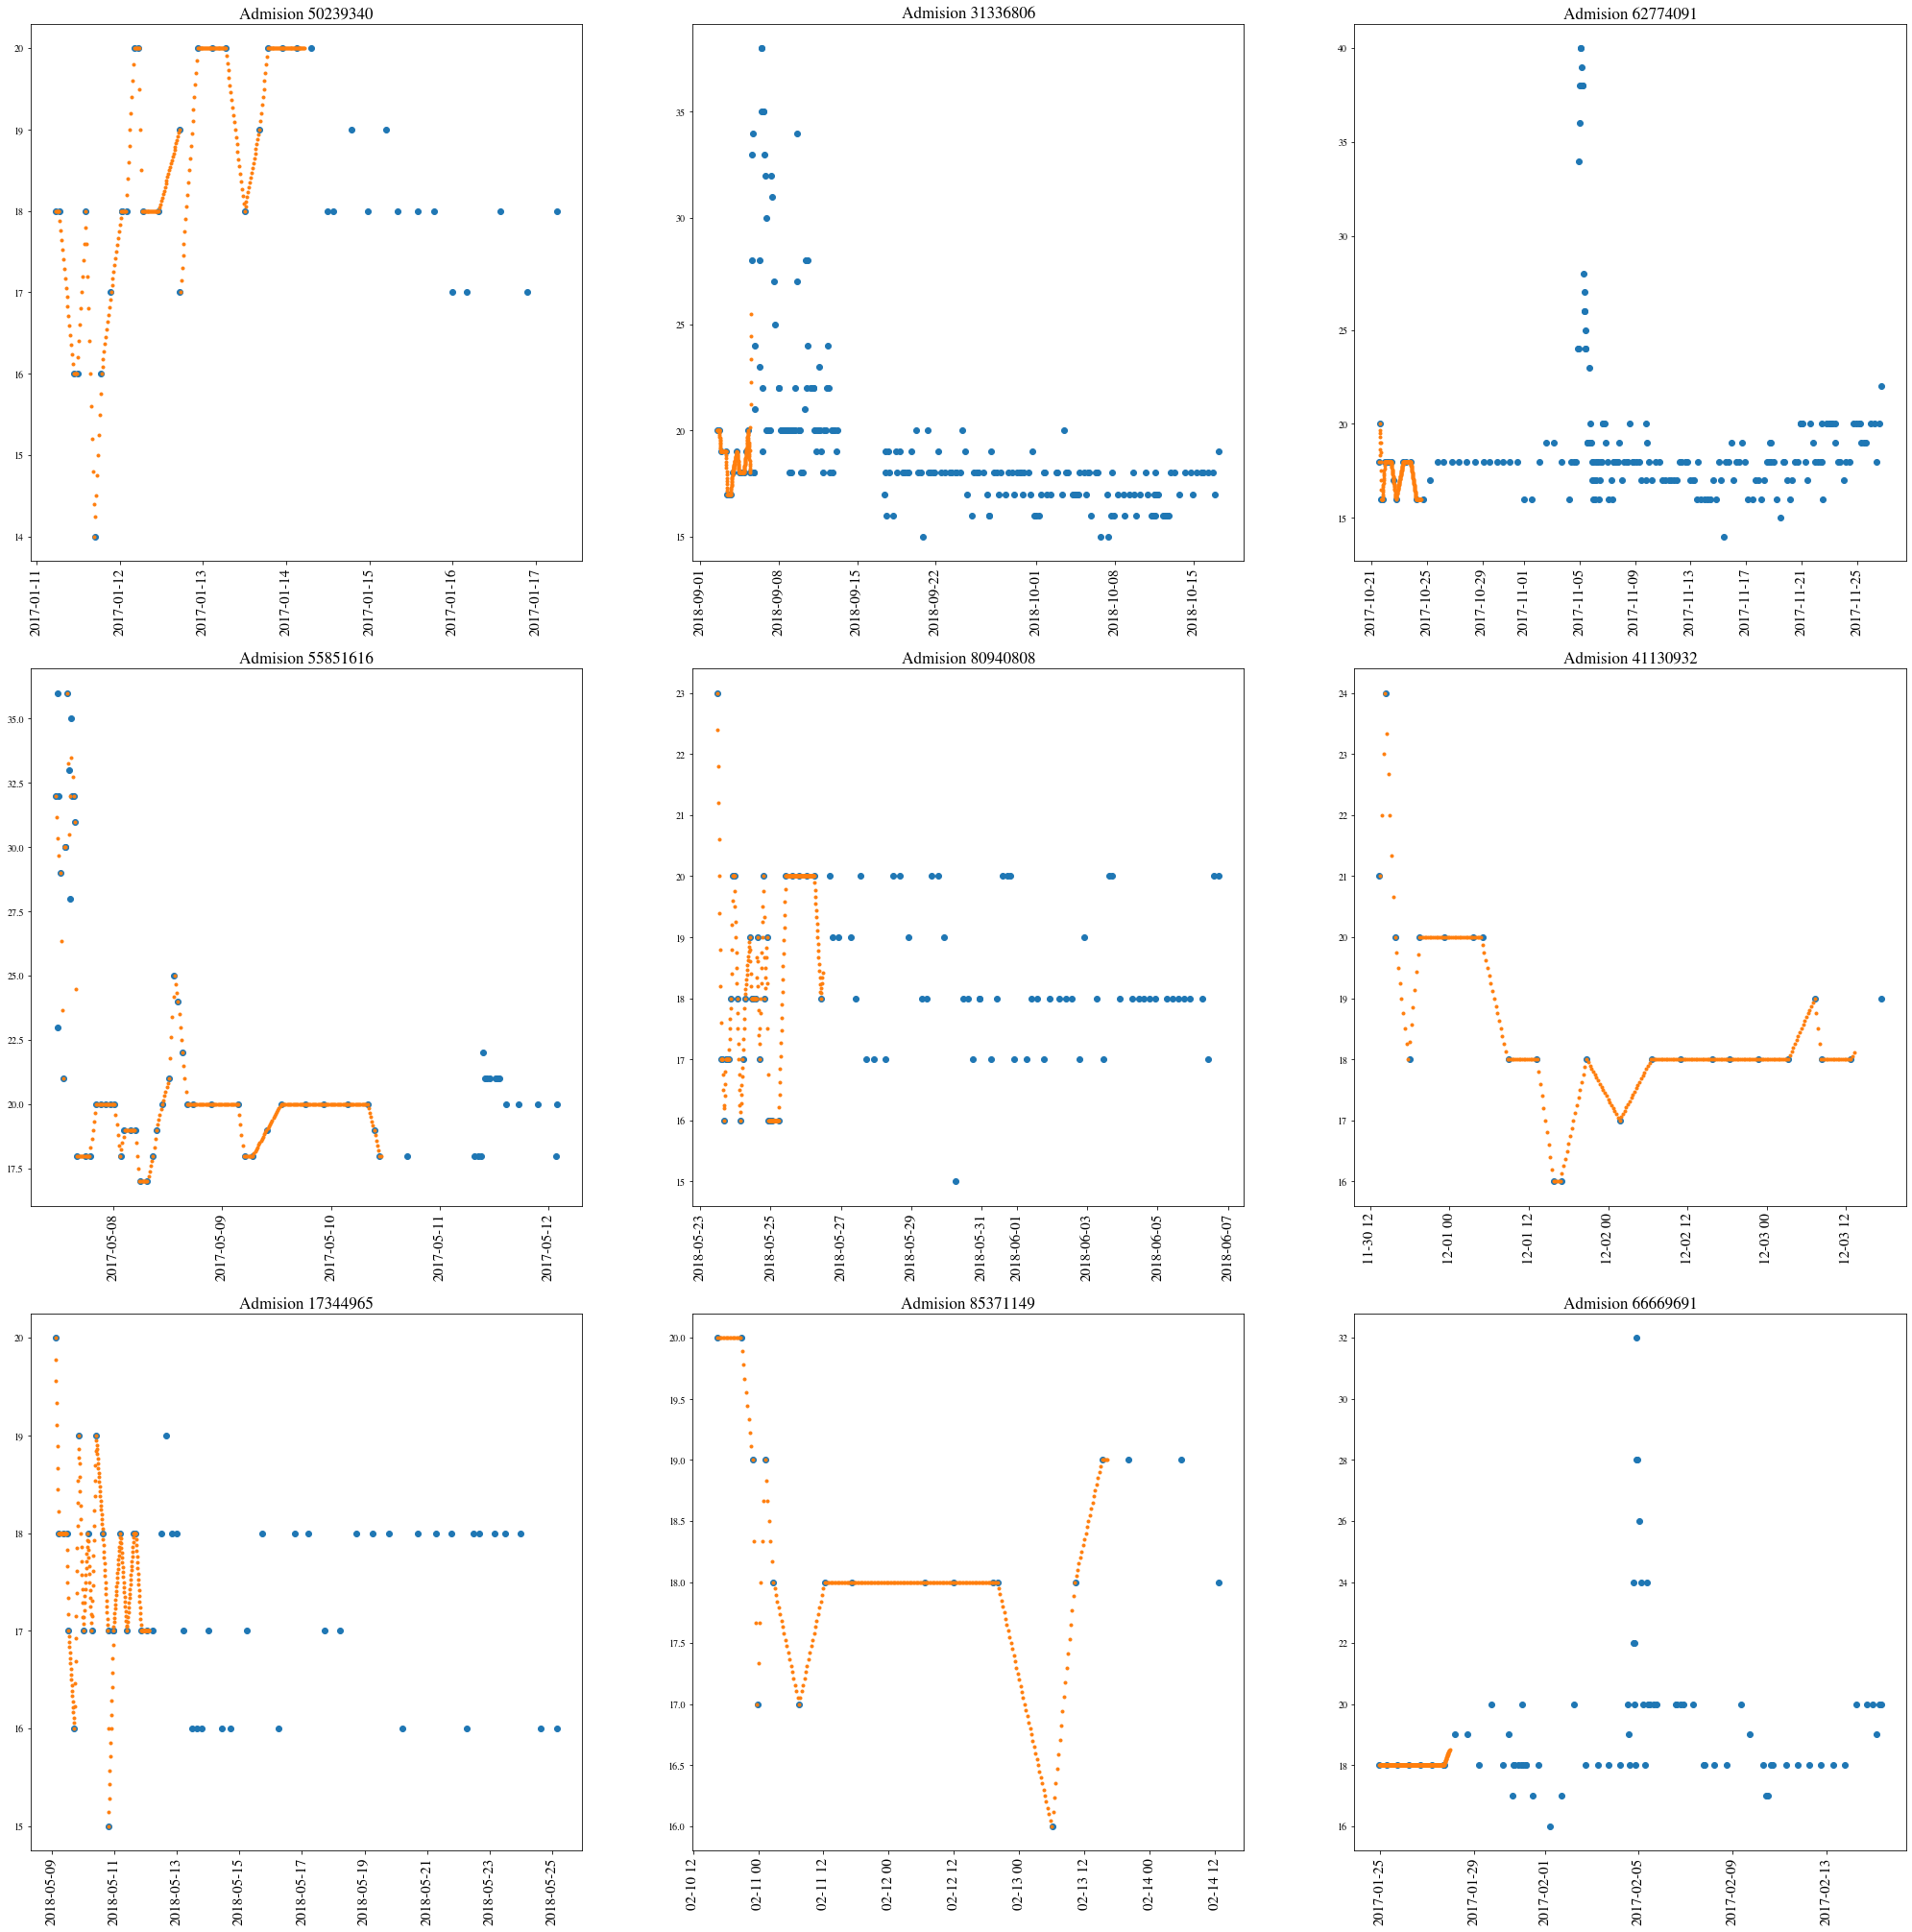

In [15]:
fig = plt.figure(figsize = (35,35))
n_plots = 9
admns = df_eobs_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)


for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    
    adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
    adm_old = df_eobs_old[df_eobs_old['admission_id'] == adm_no]
    
    ax = fig.add_subplot(3, 3, i+1)
    
    ax.plot(adm_old['timestamp'],adm_old[field], 'o')
    ax.plot(adm_new['timestamp'],adm_new[field], '.')
    ax.set_title('Admision ' + str(adm_no), fontsize = 17)
    ax.tick_params(axis = 'x',rotation = 90, labelsize = 15)
    plt.savefig(r'Images/Train_InterpolationTotalResults_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [16]:
def plot_eobs_admin(adm_no, save = False):
    adm_new = df_eobs_new[df_eobs_new['admission_id'] == adm_no]
    adm_old = df_eobs_old[(df_eobs_old['admission_id'] == adm_no) &
                         (df_eobs_old['timestamp'] <= adm_new['timestamp'].max())]

    adm_sat = df_oxyge[(df_oxyge['admission_id'] == adm_no) &
             (df_oxyge['timestamp'] <= adm_new['timestamp'].max())]
    fig = plt.figure(figsize = (35,8))
    for i,field in enumerate(dict_labels.keys()):

        ax = fig.add_subplot(1,6 , i+1)

        ax.plot(adm_new['timestamp'],adm_new[field], '.-', label = 'Interpolation')
        if field == 'Oxygen_Saturation': 
            ax.plot(adm_sat['timestamp'],adm_sat[field], 'o', label = 'Original', markersize =10)
        else:
            ax.plot(adm_old['timestamp'],adm_old[field], 'o', label = 'Original', markersize =10)

        #ax.set_title(field, fontsize = 17)
        fig.text(0.09, 0.5, 'admission ' + str(adm_no), va='center', rotation='vertical', fontsize = 30)
        ax.tick_params(axis = 'x',rotation = 90, labelsize = 20)
        ax.tick_params(axis = 'y', labelsize = 20)

    fig.text(0.145, 0.95, 'Respiratory rate', va='center', fontsize = 30)
    fig.text(0.29, 0.95, 'Heart rate', va='center', fontsize = 30)
    fig.text(0.415, 0.95, 'Temperature', va='center', fontsize = 30)
    fig.text(0.55, 0.95, 'Systolic bp', va='center', fontsize = 30)
    fig.text(0.68, 0.95, 'Diastolic bp', va='center', fontsize = 30)
    fig.text(0.80, 0.95, 'Oxygen Saturation', va='center', fontsize = 30)
    if save == True:
        plt.savefig(r'Images/Train_InterpolationEObsExample_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
    plt.show()

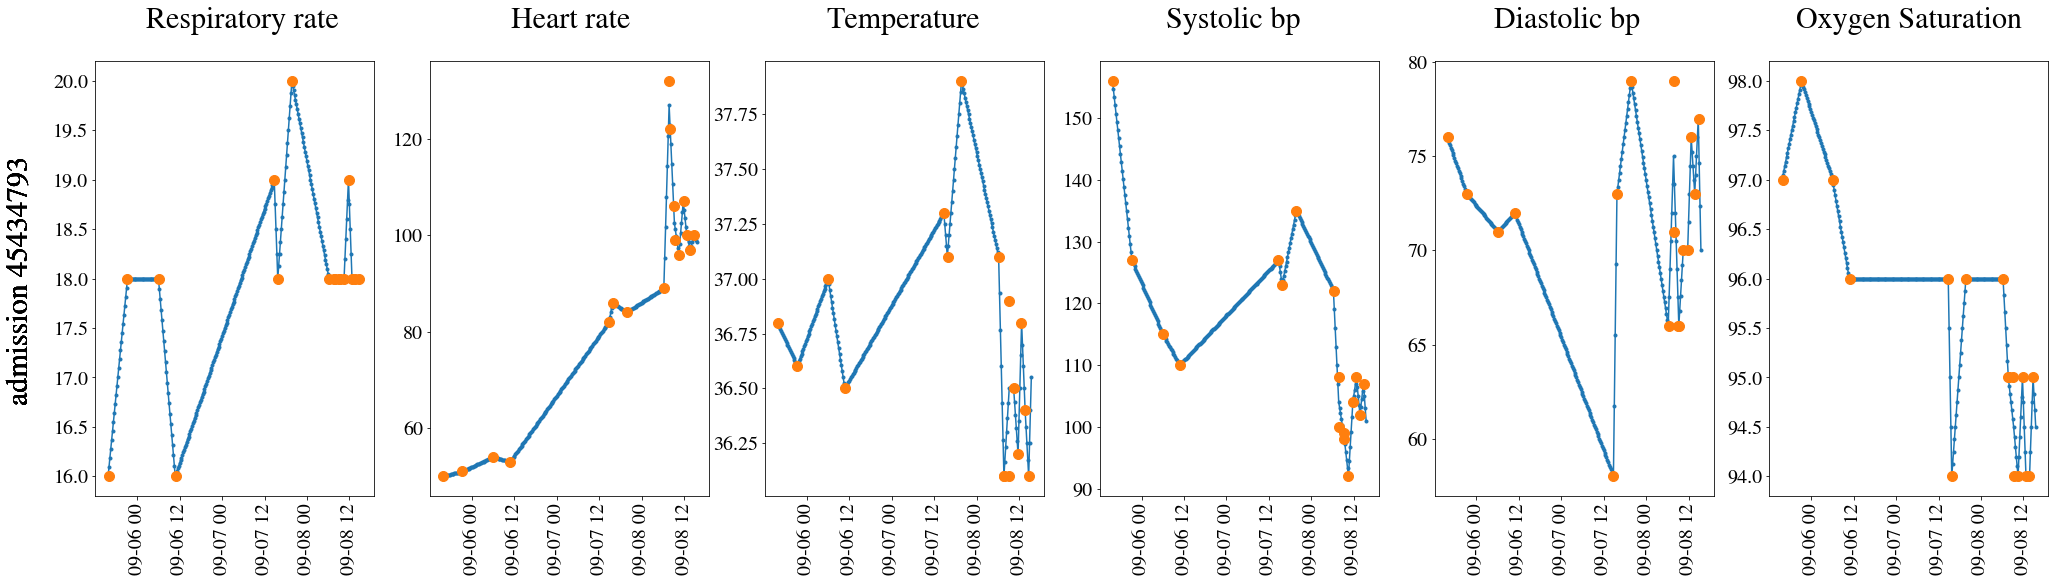

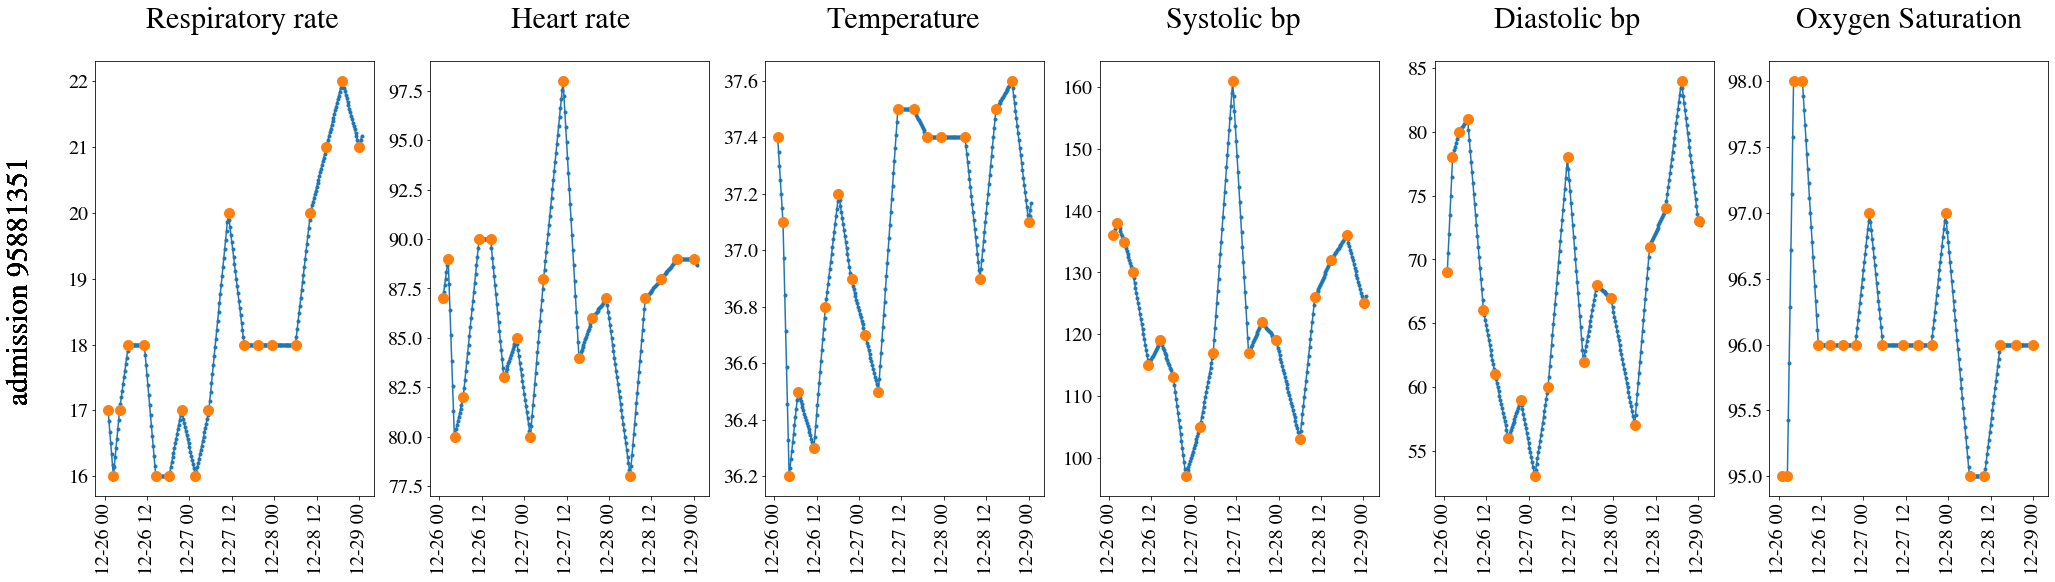

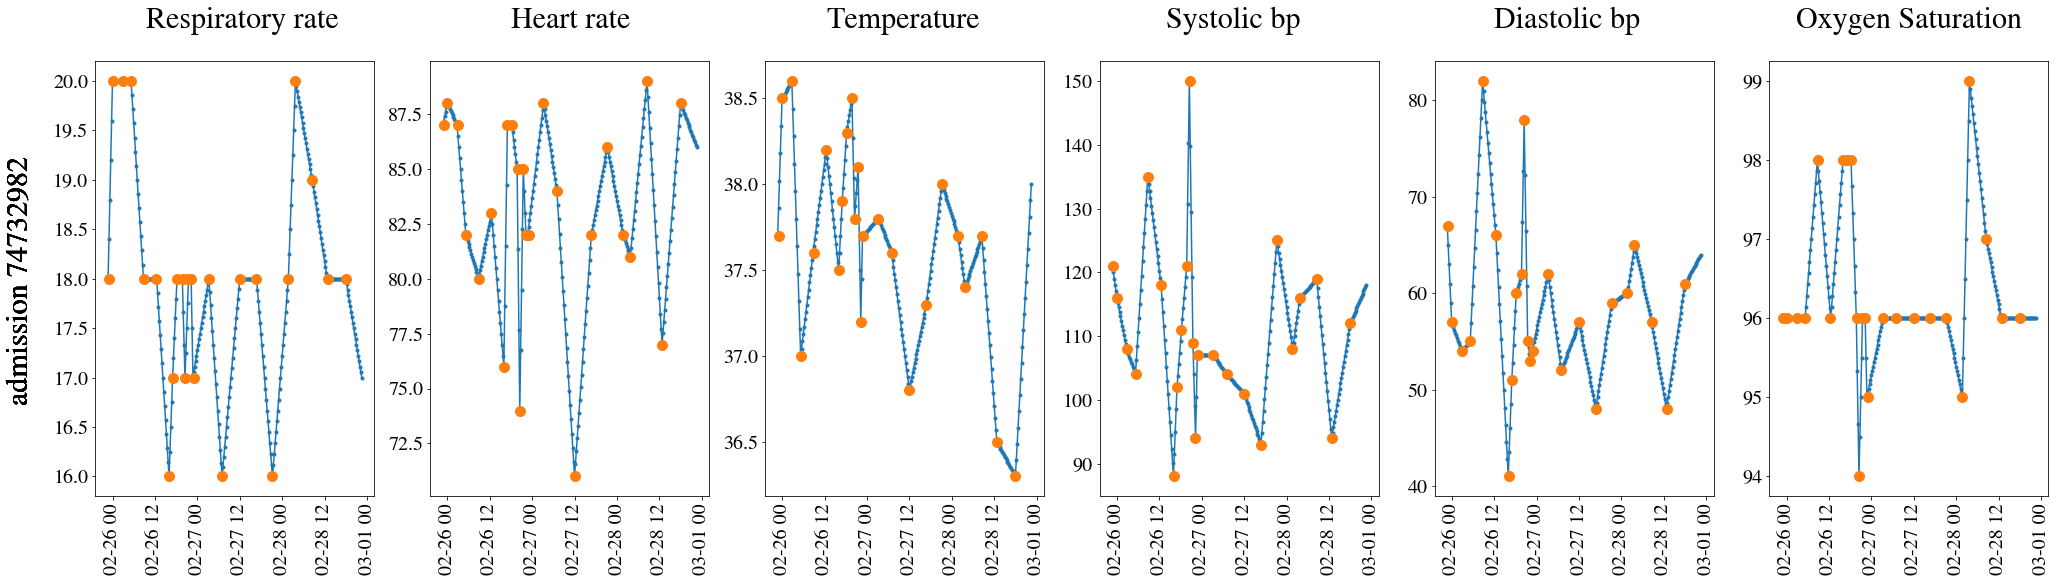

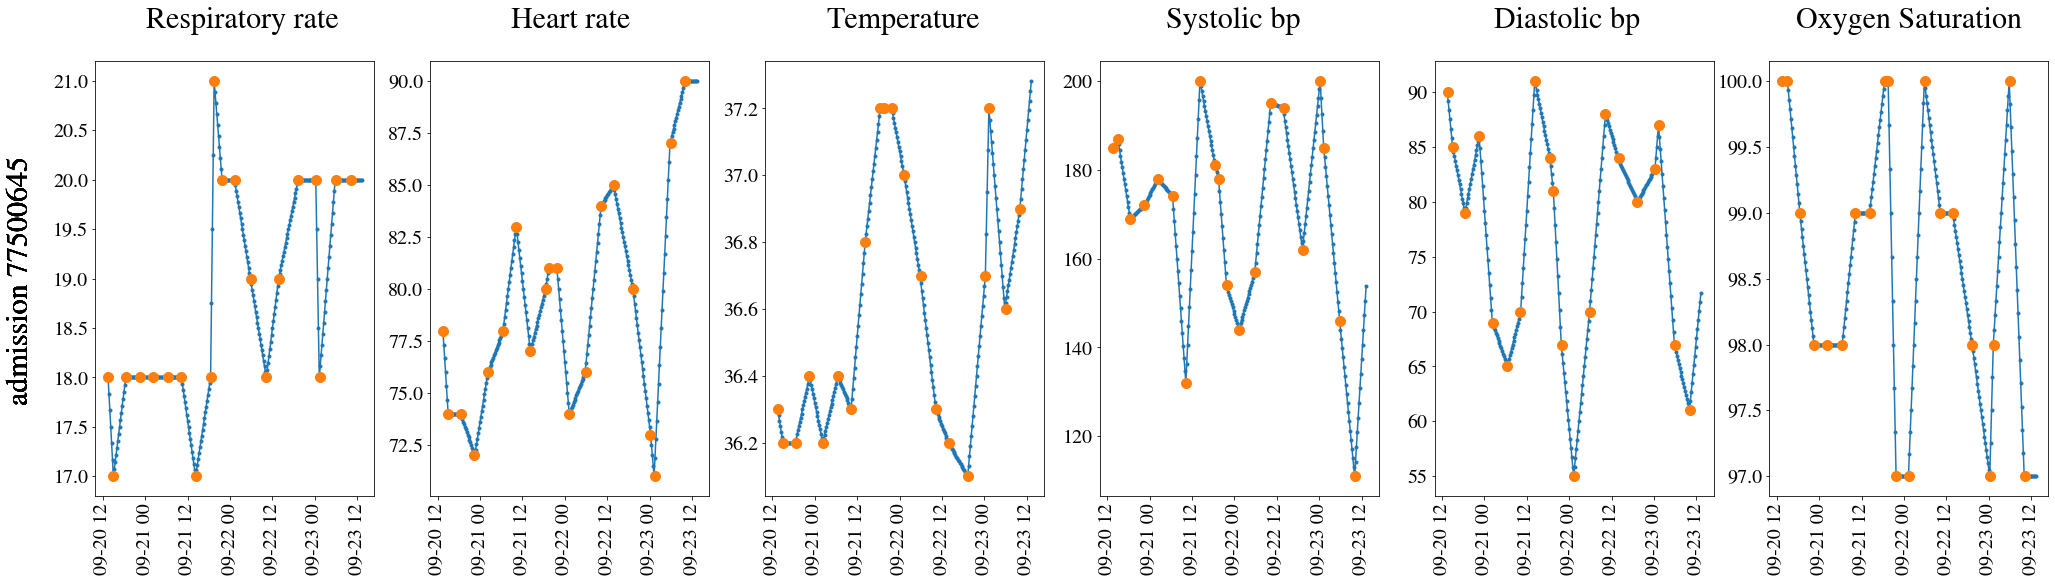

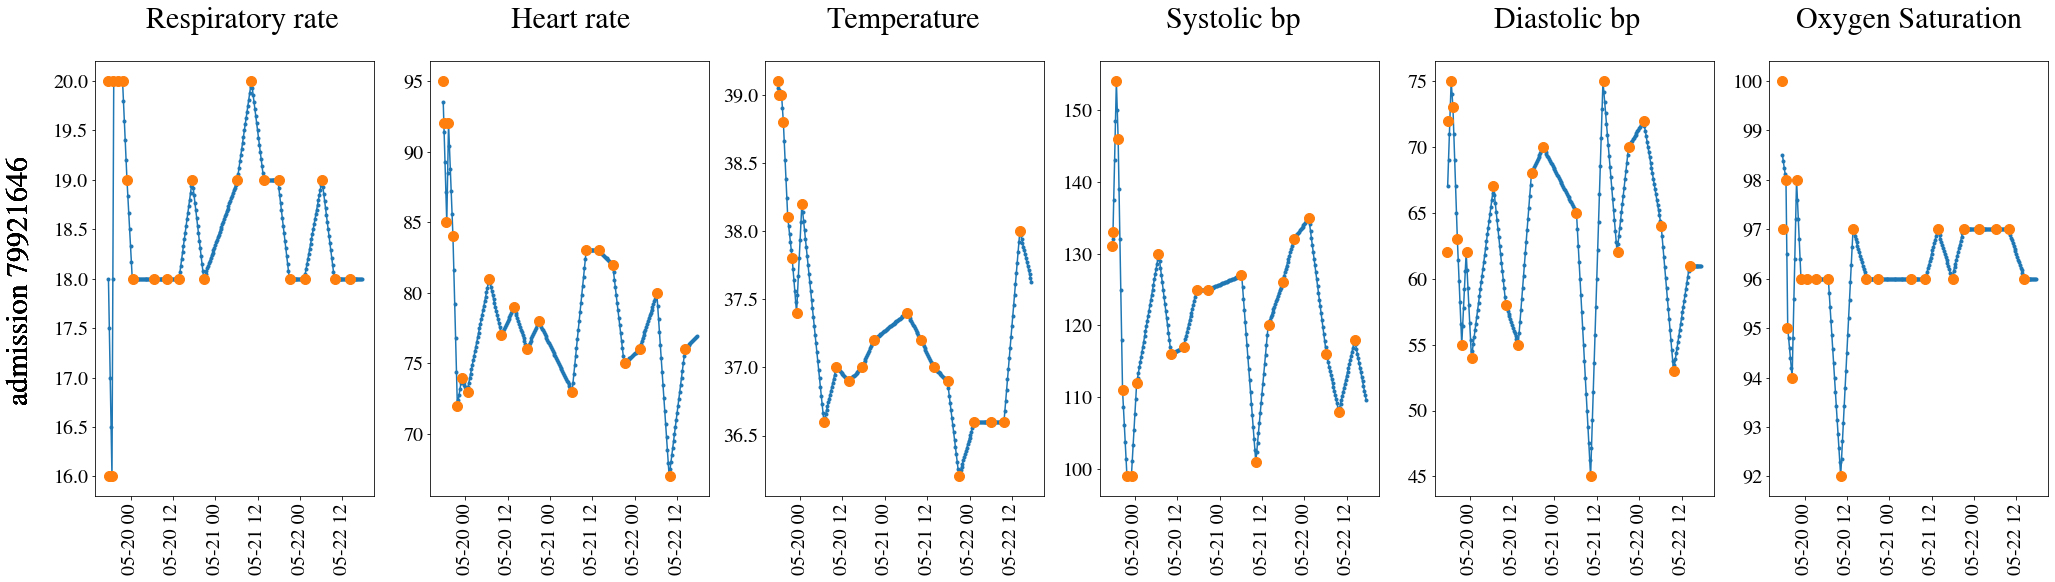

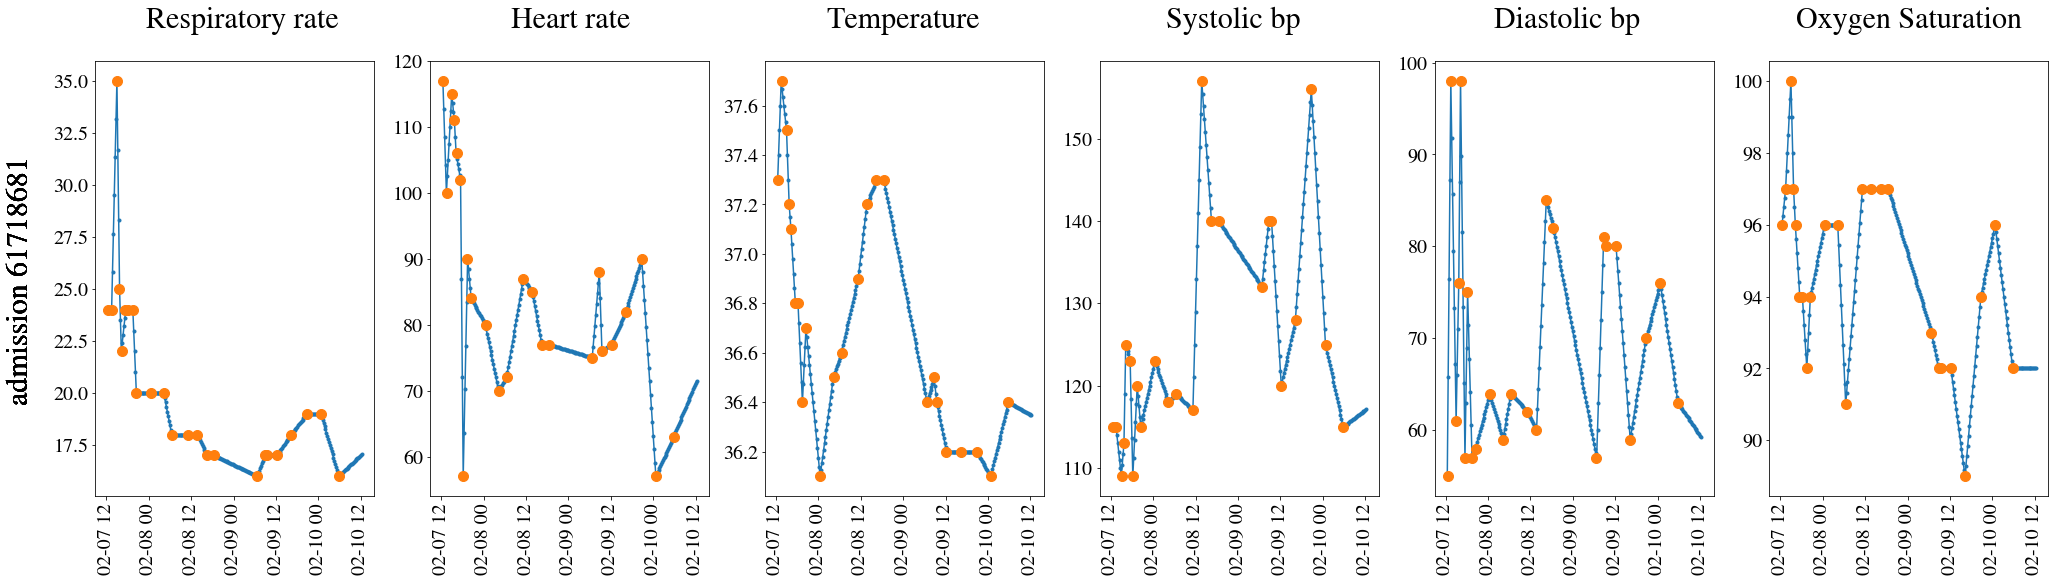

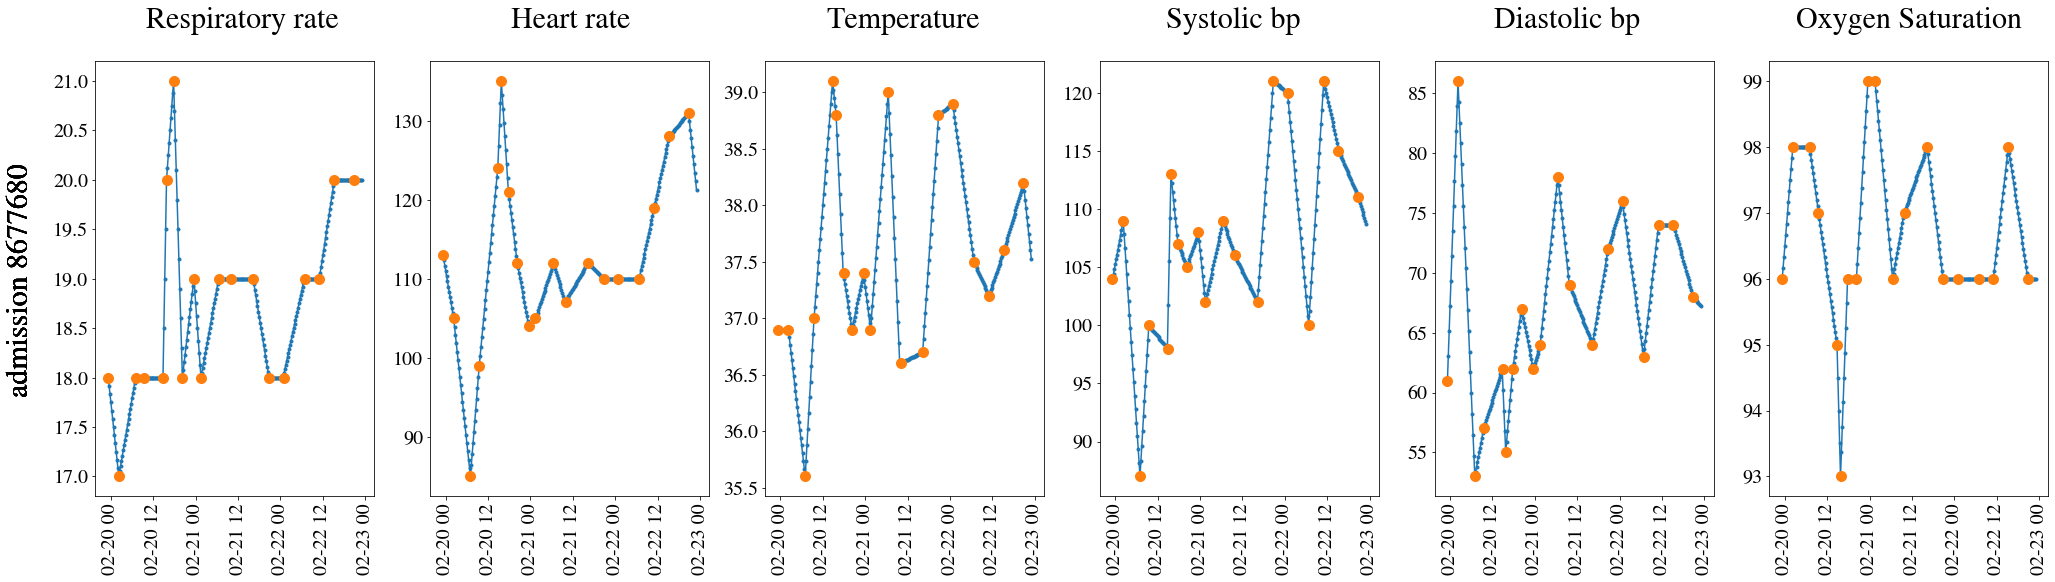

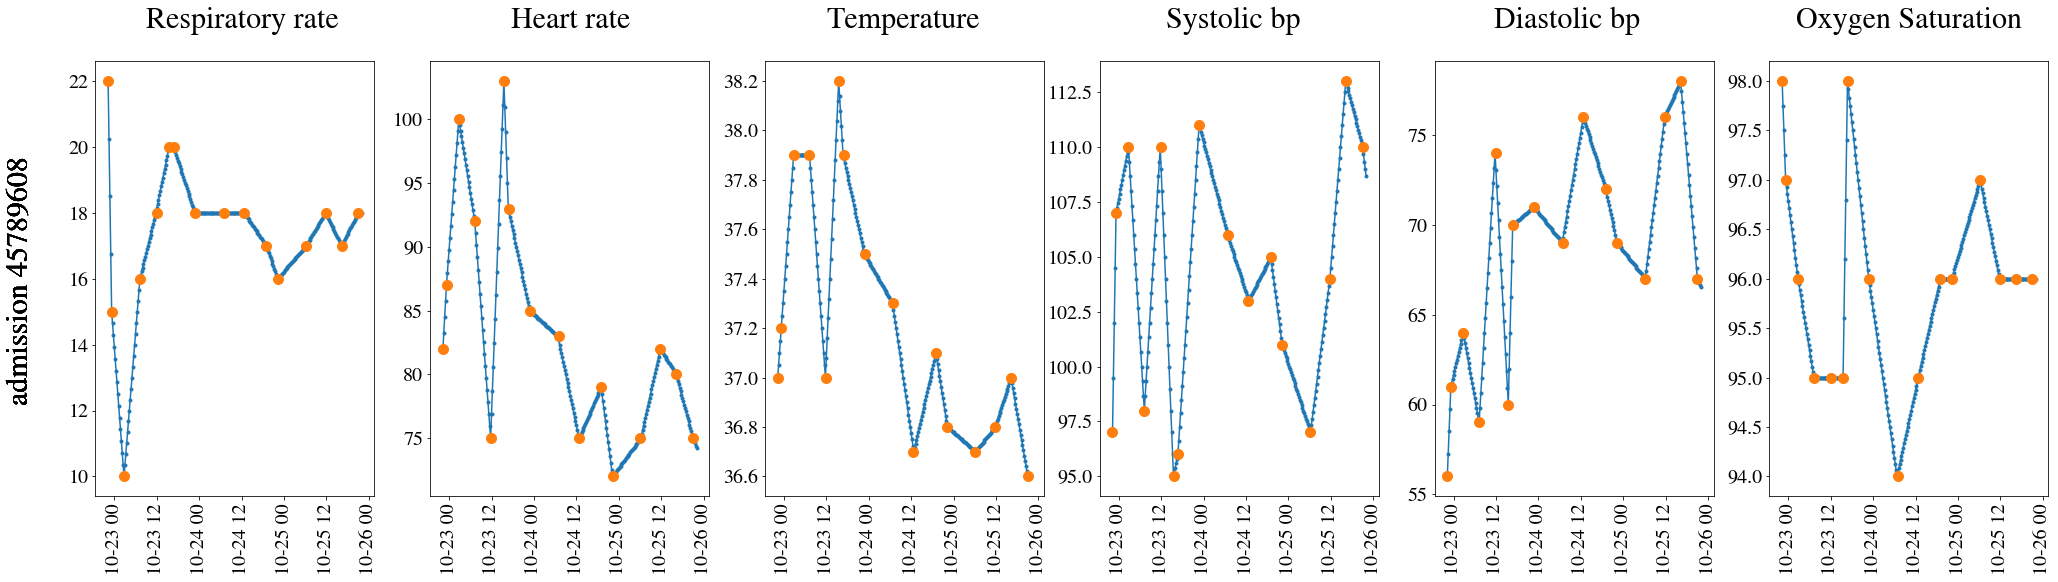

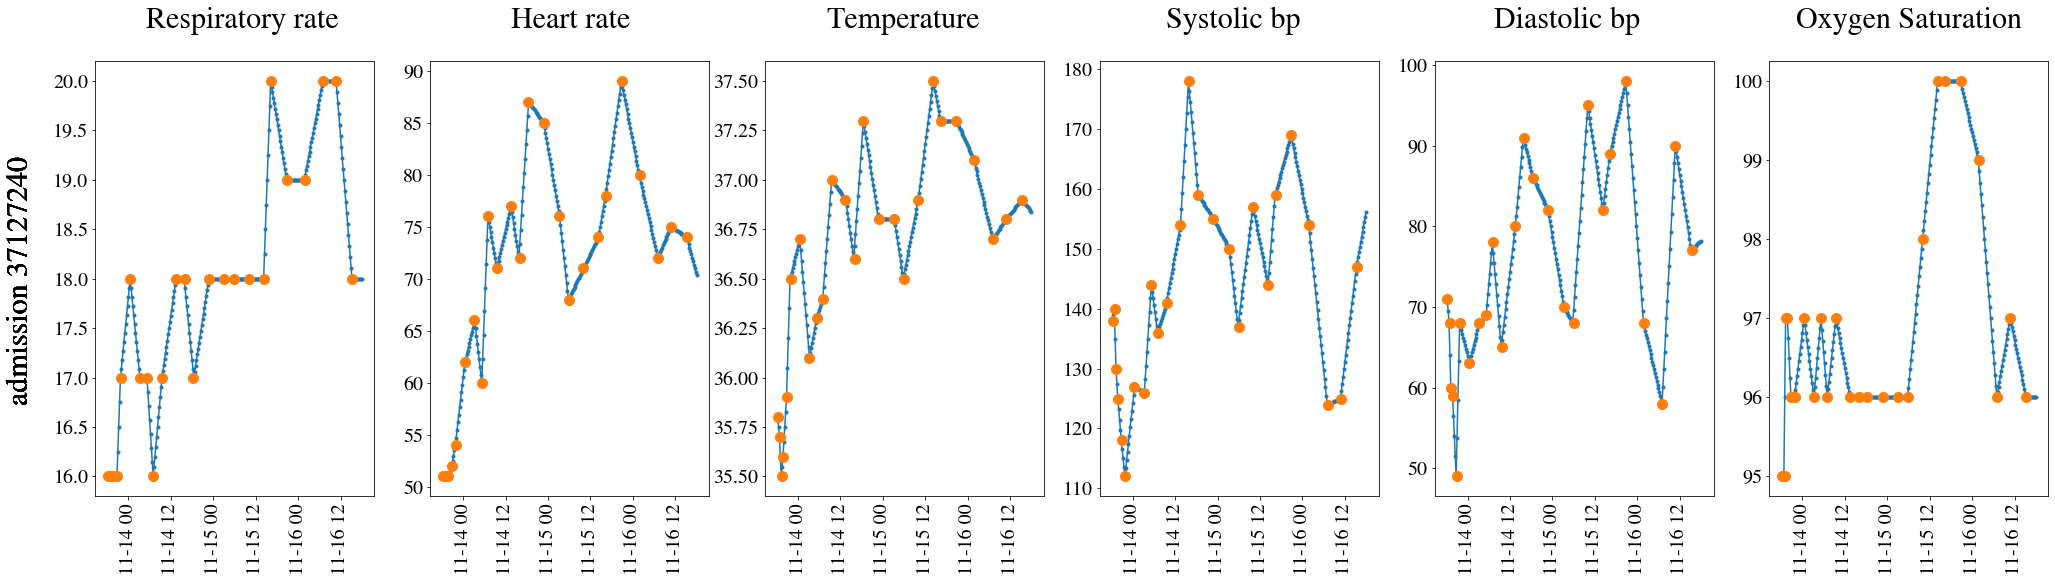

In [17]:

n_plots = 9
admns = df_eobs_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)

for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    plot_eobs_admin(adm_no, save = True)